In [20]:
# About the Brain MRI Images dataset:
# The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. 
# The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. 

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Input, ZeroPadding2D, BatchNormalization,Activation,MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from os import listdir
import imutils

%matplotlib inline

In [22]:
# In order to crop the part that contains only the brain of the image,
# I used a cropping technique to find the extreme top, bottom, left and right points of the brain.



def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]  


    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image      


In [23]:
# The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data 
# and the second argument is the image size, and for every image in both directories and does the following:

# Read the image. Crop the part of the image representing only the brain. 
# Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). 
# So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network. 
# Apply normalization because we want pixel values to be scaled to the range 0-1.
# Append the image to X and its label to y. 
# After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
# Finally, Return X and y

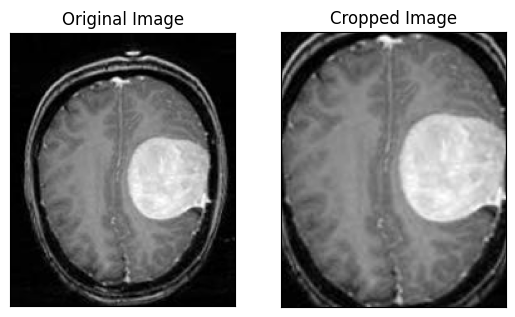

In [24]:
ex_img = cv2.imread("C:\\Users\\DELL\\OneDrive\\Documents\\BrainTumor_Det\\augmented data\\yes\\aug_Y1_0_2900.jpg")
ex_new_img = crop_brain_contour(ex_img,True)

In [25]:
# LOADING UP THE DATA


def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    

    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [26]:
augmented_path = "C:\\Users\\DELL\\OneDrive\\Documents\\BrainTumor_Det\\augmented data"

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path +"\\yes"  
augmented_no = augmented_path + "\\no"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [27]:
# PLOTTING SAMPLE IMAGES

def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

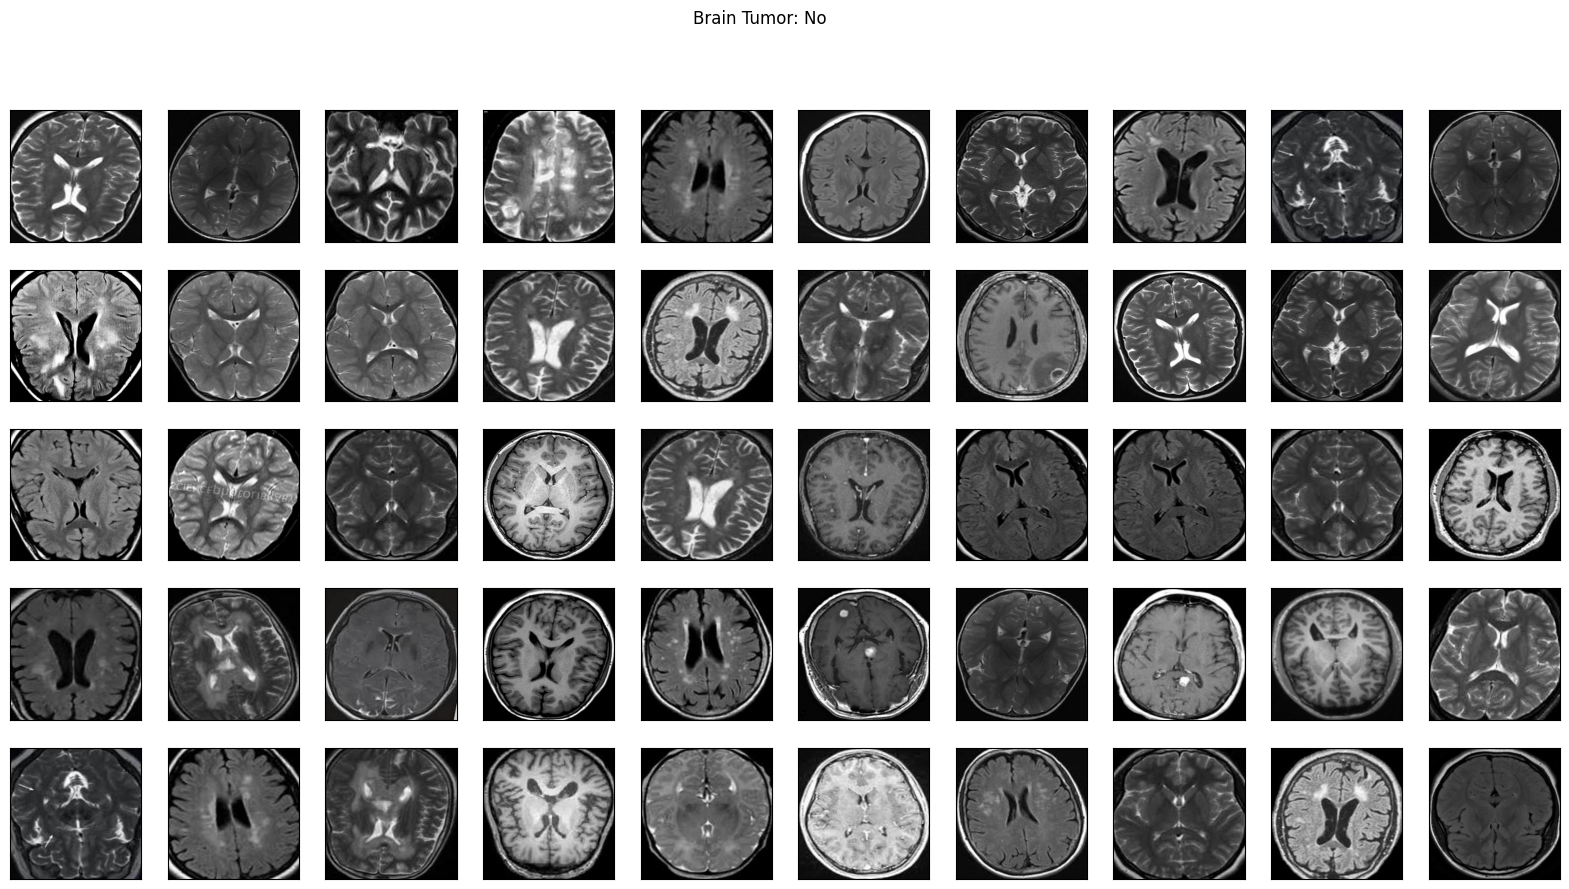

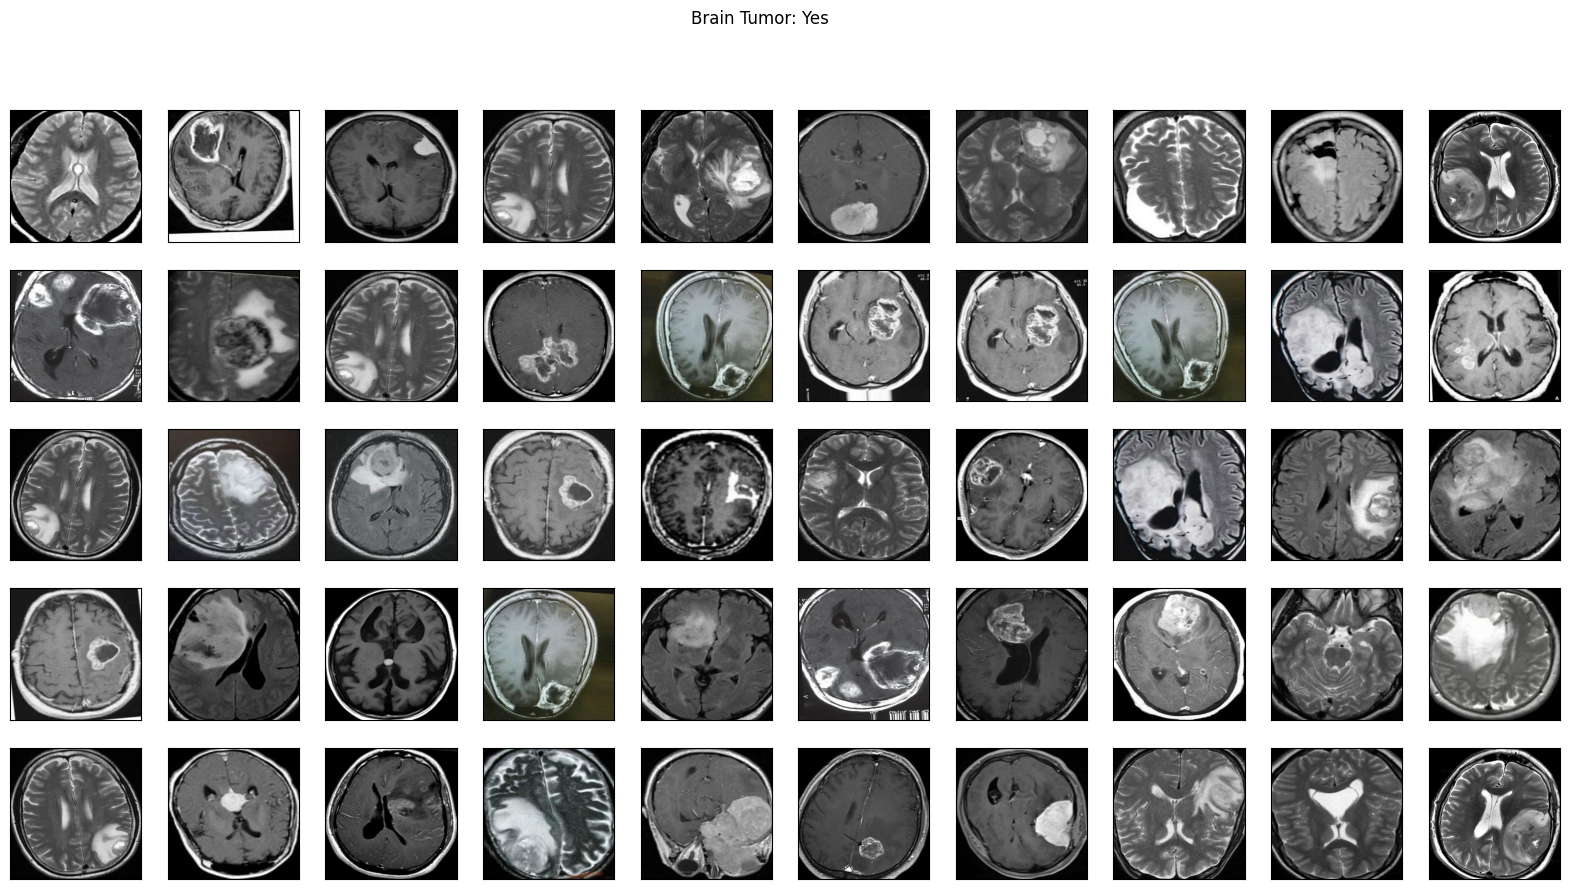

In [28]:
plot_sample_images(X,y)

In [29]:
# SPLITTING THE TRAINING DATA

def split_data(X, y, test_size=0.2):
       
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


# 70% of the data for training.
# 15% of the data for validation.
# 15% of the data for testing.

In [30]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [31]:

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [32]:
# HELPER FUNCTIONS:

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [49]:
# MAIN MODEL::


def build_model(input_shape):
    
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    
    X_input = Input(input_shape)
    #shape = (?,240,240,3) 3-> no of channels
    
    X = ZeroPadding2D((2,2))(X_input)
    #shape = (?,244,244,3)
    
    X = Conv2D(32,(7,7),strides=(1,1),name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = Conv2D(32,(7,7),strides=(1,1),name = 'conv1')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    
    X = Flatten()(X)
    
    X = Dense(128,activation = 'relu',name='fc')(X)
    X = Dense(128,activation = 'relu',name='fc1')(X)
    X = Dense(1,activation = 'sigmoid',name='fc2')(X)
    
    model = Model(inputs = X_input,outputs = X,name='BrainDetectionModel')
    model.save()
    return model

In [50]:

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [51]:
model = build_model(IMG_SHAPE)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_18496\3943338430.py", line 1, in <module>
    model = build_model(IMG_SHAPE)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_18496\3032582506.py", line 34, in build_model
    model.save()
  File "c:\Users\DELL\AppData\Local\Programs\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\DELL\AppData\Local\Programs\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 119, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.save() missing 1 required positional argumen

In [52]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 53, 53, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,292,069 (8.74 MB)

 Trainable params: 764,001 (2.91 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,528,004 (5.83 MB)

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [55]:
from keras.callbacks import ModelCheckpoint

# Define the file path for saving the model with .keras extension
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')


In [56]:
# TRAINING THE MODEL

start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9450 - loss: 0.1358
Epoch 1: val_accuracy improved from -inf to 0.92903, saving model to models/cnn-parameters-improvement-01-0.93.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 878ms/step - accuracy: 0.9452 - loss: 0.1356 - val_accuracy: 0.9290 - val_loss: 0.3499
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9804 - loss: 0.0665
Epoch 2: val_accuracy did not improve from 0.92903
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 821ms/step - accuracy: 0.9803 - loss: 0.0666 - val_accuracy: 0.8774 - val_loss: 0.4353
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9860 - loss: 0.0325
Epoch 3: val_accuracy did not improve from 0.92903
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 829ms/step - accuracy: 0.9859 - loss: 0.0326 - val_accuracy: 0.8774 - val_loss: 0.6169
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9808 - loss: 0.0525
Epoch 4: val_accuracy did not improve from 0.92903
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 8

In [57]:
# start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# end_time = time.time()
# execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

In [58]:
# start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# end_time = time.time()
# execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

In [59]:
history = model.history.history


for key in history.keys():
    print(key)


accuracy
loss
val_accuracy
val_loss


In [60]:
# PLOTTING LOSSES AND ACCURACY

def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

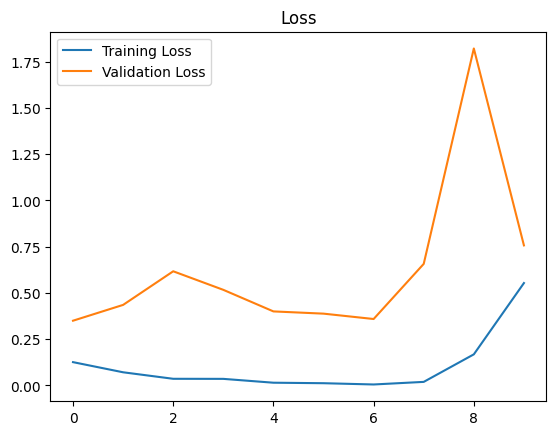

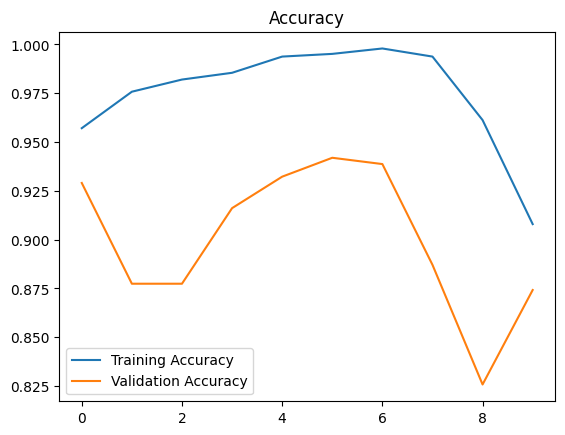

In [61]:
plot_metrics(history) 

In [48]:
from keras.models import load_model

# Provide the path to the best model
best_model_filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# Load the model
best_model = load_model(best_model_filepath)


ValueError: File not found: filepath=models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras. Please ensure the file is an accessible `.keras` zip file.